In [39]:
%pylab inline
sc.version

Populating the interactive namespace from numpy and matplotlib


u'1.3.1'

In [94]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 7

In [130]:
from xmltodict import parse as parse_xml
from dateutil.parser import parse as parse_date
import re
from datetime import datetime
from collections import Counter
from os.path import join as path_join

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [155]:
DATA_FOLDER = '/Users/friso/Downloads/se/'
LEARN_PERIOD = 7
PREDICT_PERIOD = 28

In [42]:
def xml_to_rdd(file_name):
    def infer_type(input):
        int_re = re.compile('^[\-]?[0-9]+$')
        date_re = re.compile('^[0-9]{4}-[0-9]{2}-[0-9]{2}T[0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{3}$')
        int_type = (int_re.match, int)
        date_type = (date_re.match, parse_date)
        default_type = (lambda x: True, lambda x: x)

        for f, c in [int_type, date_type, default_type]:
            if f(input):
                return c(input)

    def clean_xml_dict(xd):
        return {
                key[1:]: infer_type(value.strip())
                for key, value in xd.items() if key.startswith('@')
            }

    return sc.textFile(file_name)\
    .filter(lambda line: line.strip().startswith('<row'))\
    .map(lambda line: parse_xml(line))\
    .map(lambda xml_dict: xml_dict['row'])\
    .map(clean_xml_dict)

def extract_fields(row, wanted):
    return {
        k: row.get(k, None)
        for k in wanted
    }

def rdd_to_df(rdd, columns, sql_context, schema=None):
    rows = rdd.map(lambda r: extract_fields(r, columns))\
    .map(lambda r: Row(**r))
    
    return sql_context.createDataFrame(rows, schema, 0.1)

def add_to_dict(input, key, value):
    input[key] = value
    return input

In [43]:
posts = xml_to_rdd(path_join(DATA_FOLDER, 'Posts.xml'))
posts.take(1)

[{u'AcceptedAnswerId': 393,
  u'AnswerCount': 4,
  u'Body': u"<p>My fianc\xe9e and I are looking for a good Caribbean cruise in October and were wondering which islands are best to see and which Cruise line to take?</p>\n\n<p>It seems like a lot of the cruises don't run in this month due to Hurricane season so I'm looking for other good options.</p>\n\n<p><strong>EDIT</strong> We'll be travelling in 2012.</p>",
  u'ClosedDate': datetime.datetime(2013, 2, 25, 23, 52, 47, 953000),
  u'CommentCount': 4,
  u'CreationDate': datetime.datetime(2011, 6, 21, 20, 19, 34, 730000),
  u'FavoriteCount': 1,
  u'Id': 1,
  u'LastActivityDate': datetime.datetime(2012, 5, 24, 14, 52, 14, 760000),
  u'LastEditDate': datetime.datetime(2011, 12, 28, 21, 36, 43, 910000),
  u'LastEditorUserId': 101,
  u'OwnerUserId': 9,
  u'PostTypeId': 1,
  u'Score': 8,
  u'Tags': u'<caribbean><cruising><vacation>',
  u'Title': u'What are some Caribbean cruises for October?',
  u'ViewCount': 309}]

In [44]:
votes = xml_to_rdd(path_join(DATA_FOLDER, 'Votes.xml'))
votes.take(1)

[{u'CreationDate': datetime.datetime(2011, 6, 21, 0, 0),
  u'Id': 1,
  u'PostId': 1,
  u'VoteTypeId': 2}]

In [45]:
max_datetime = posts.map(lambda p: p['CreationDate']).max()

In [46]:
max_datetime

datetime.datetime(2014, 9, 14, 0, 11, 54, 480000)

In [30]:
post_votes = posts\
.filter(lambda p: p['PostTypeId'] == 1)\
.filter(lambda p: (max_datetime - p['CreationDate']).days > 35)\
.keyBy(lambda p: p['Id'])\
.join(votes.keyBy(lambda v: v['PostId']))

In [31]:
post_votes.take(1)

[(4,
  ({u'AnswerCount': 1,
    u'Body': u"<p>Singapore Airlines has an all-business class flight from EWR-SIN (Newark->Singapore), but I can't seem to find any reward Krisflyer flights for <em>any</em> dates.  </p>",
    u'CommentCount': 1,
    u'CreationDate': datetime.datetime(2011, 6, 21, 20, 24, 57, 160000),
    u'Id': 4,
    u'LastActivityDate': datetime.datetime(2013, 1, 9, 9, 55, 22, 743000),
    u'LastEditDate': datetime.datetime(2013, 1, 9, 9, 55, 22, 743000),
    u'LastEditorUserId': 693,
    u'OwnerUserId': 24,
    u'PostTypeId': 1,
    u'Score': 8,
    u'Tags': u'<loyalty-programs><routes><ewr><singapore-airlines><sin>',
    u'Title': u'Does Singapore Airlines offer any reward seats on their EWR-SIN route?',
    u'ViewCount': 209},
   {u'CreationDate': datetime.datetime(2011, 6, 21, 0, 0),
    u'Id': 27,
    u'PostId': 4,
    u'VoteTypeId': 2}))]

In [156]:
def make_vote_dist( (post_id, votes) ):
    vote_types = {
        1: 'AcceptedByOriginator',
        2: 'UpMod',
        3: 'DownMod',
        4: 'Offensive',
        5: 'Favorite',
        6: 'Close',
        7: 'Reopen',
        8: 'BountyStart',
        9: 'BountyClose',
        10: 'Deletion',
        11: 'Undeletion',
        12: 'Spam',
        15: 'ModeratorReview',
        16: 'ApproveEditSuggestion'
    }
    X = Counter()
    X.update([
            vote_types[vote['VoteTypeId']]
            for vote in votes if (vote['CreationDate'] - vote['PostCreationDate']).days <= LEARN_PERIOD
        ])
    
    Y = Counter()
    Y.update([
            vote_types[vote['VoteTypeId']]
            for vote in votes if ((vote['CreationDate'] - vote['PostCreationDate']).days > LEARN_PERIOD and
                                  (vote['CreationDate'] - vote['PostCreationDate']).days <= LEARN_PERIOD + PREDICT_PERIOD)
        ])
    return {
            'Id': post_id,
            'X': X,
            'Y': Y
        }
    
vote_distributions = post_votes\
.map(lambda (id, (post, vote)): (id, add_to_dict(vote, 'PostCreationDate', post['CreationDate'])))\
.groupByKey()\
.map(make_vote_dist)

In [157]:
vote_distributions.take(5)

[{'Id': 4,
  'X': Counter({'UpMod': 3, 'DownMod': 1}),
  'Y': Counter({'UpMod': 1})},
 {'Id': 8,
  'X': Counter({'UpMod': 2, 'DownMod': 1}),
  'Y': Counter({'UpMod': 1})},
 {'Id': 6828, 'X': Counter({'UpMod': 8}), 'Y': Counter()},
 {'Id': 16,
  'X': Counter({'UpMod': 12, 'Favorite': 3}),
  'Y': Counter({'UpMod': 7, 'Favorite': 1})},
 {'Id': 9560, 'X': Counter({'UpMod': 3}), 'Y': Counter()}]

In [158]:
def features(vd):
    result = dict(vd['X'])
    result.update({ 'Y_' + k : v for k,v in vd['Y'].items() })
    return result

df = pd.DataFrame(vote_distributions.map(features).collect())

In [159]:
df['TotalMod'] = df.UpMod + df.DownMod
df['DiffMod'] = df.UpMod - df.DownMod
df['Y_TotalMod'] = df.Y_UpMod + df.Y_DownMod

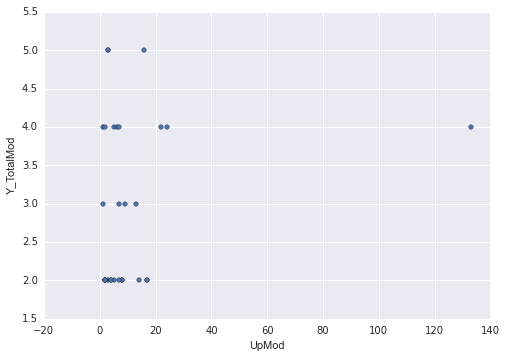

In [160]:
df.plot(kind='scatter', x='UpMod', y='Y_TotalMod')

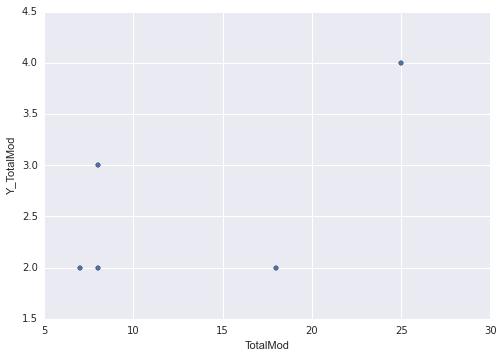

In [161]:
df.plot(kind='scatter', x='TotalMod', y='Y_TotalMod')

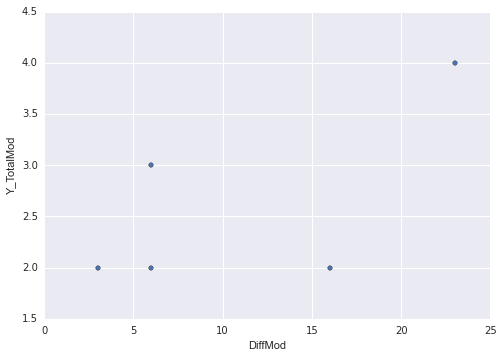

In [162]:
df.plot(kind='scatter', x='DiffMod', y='Y_TotalMod')

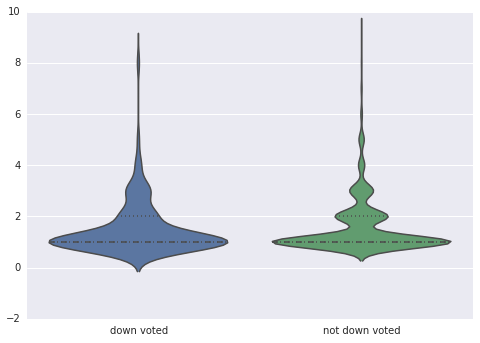

In [163]:
sns.violinplot([
        df[df.DownMod > 0].Y_UpMod.dropna(),
        df[df.DownMod.isnull()].Y_UpMod.dropna()
        ],
        names=["down voted", "not down voted"])